<a href="https://colab.research.google.com/github/lmontaldo/meli_prueba/blob/Jupyter-Colabs/Series_de_tiempo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Series de tiempo

Problema: pronosticar la cantidad de unidades diarias que van a
vender 3 categorías distintas de MELI

El objetivo de este desafío es construir un modelo de forecast que permita estimar las
ventas de 3 semanas a nivel diario utilizando la historia de ventas de la categoría. Es
decir, predecir las ventas de los siguientes 21 días. 


Las métricas y la medición de la
performance del forecast son un punto clave de este desafío.


TIP: Dividir el dataset en entrenamiento, testing y validación correctamente es muy
importante en problemas de forecasting!

In [1]:
! pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# import the regression module
from pycaret.regression import *

In [3]:
import numpy as np
import pandas as pd, datetime
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from time import time
import os
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
import xgboost as xgb
#from fbprophet import Prophet
import warnings
warnings.filterwarnings('ignore')

In [4]:
import datetime
import plotly
import plotly.express as px

In [5]:
! git clone https://github.com/lmontaldo/meli_prueba.git


Cloning into 'meli_prueba'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (20/20), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 20 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (20/20), done.


In [6]:
s='https://raw.githubusercontent.com/lmontaldo/meli_prueba/Datos/series.csv'

In [7]:
df=pd.read_csv(s,low_memory=False, header=[0],sep=',')

In [8]:
df.head()

,CATEGORY,DATE,UNITS_SOLD
0,CATEG-1,2021-08-17,59
1,CATEG-1,2020-09-19,40
2,CATEG-2,2021-10-26,23
3,CATEG-1,2021-04-27,60
4,CATEG-2,2021-05-05,61


In [9]:
df=df.set_index('DATE')

In [10]:
df.index = pd.to_datetime(df.index)

In [11]:
df_si=df.reset_index()

In [12]:
df.shape

(2686, 2)

In [13]:
df.index.min(), df.index.max()

(Timestamp('2018-09-24 00:00:00'), Timestamp('2021-11-12 00:00:00'))

In [14]:
df['year'] = pd.DatetimeIndex(df.index).year
df['month'] = pd.DatetimeIndex(df.index).month
df['day'] = pd.DatetimeIndex(df.index).day
df['dayofweek']=pd.DatetimeIndex(df.index).dayofweek

In [15]:
df.columns

Index(['CATEGORY', 'UNITS_SOLD', 'year', 'month', 'day', 'dayofweek'], dtype='object')

In [16]:
df.sort_index().head(3)

,CATEGORY,UNITS_SOLD,year,month,day,dayofweek
DATE,,,,,,
2018-09-24,CATEG-3,0,2018,9,24,0
2018-09-25,CATEG-3,0,2018,9,25,1
2018-09-27,CATEG-3,0,2018,9,27,3


## Análisis de las series

### Visualizaciones e insights preliminares

In [17]:
df_si=df.reset_index()

In [18]:
gp_df=df_si.groupby(['DATE', 'CATEGORY']).agg({'UNITS_SOLD':'sum'}).reset_index()

In [19]:
gp_df.head()

,DATE,CATEGORY,UNITS_SOLD
0,2018-09-24,CATEG-3,0
1,2018-09-25,CATEG-3,0
2,2018-09-27,CATEG-3,0
3,2018-09-28,CATEG-3,2
4,2018-09-29,CATEG-3,1


In [20]:
fig = px.line(gp_df, x='DATE', y='UNITS_SOLD', color='CATEGORY', title='Unidades vendidas por categoría')
fig.show()

In [21]:
df=df.sort_index(ascending=True)

In [22]:
df.columns

Index(['CATEGORY', 'UNITS_SOLD', 'year', 'month', 'day', 'dayofweek'], dtype='object')

In [23]:
df[df['UNITS_SOLD']==0].tail()

,CATEGORY,UNITS_SOLD,year,month,day,dayofweek
DATE,,,,,,
2018-10-29,CATEG-3,0,2018,10,29,0
2018-11-03,CATEG-3,0,2018,11,3,5
2018-11-05,CATEG-3,0,2018,11,5,0
2018-11-08,CATEG-3,0,2018,11,8,3
2018-11-11,CATEG-3,0,2018,11,11,6


In [24]:
df_si.isnull().sum()

DATE          0
CATEGORY      0
UNITS_SOLD    0
year          0
month         0
day           0
dayofweek     0
dtype: int64

In [25]:
gp_t=df_si.groupby(["month", 'year','CATEGORY']).agg({'UNITS_SOLD':'sum'}).reset_index()

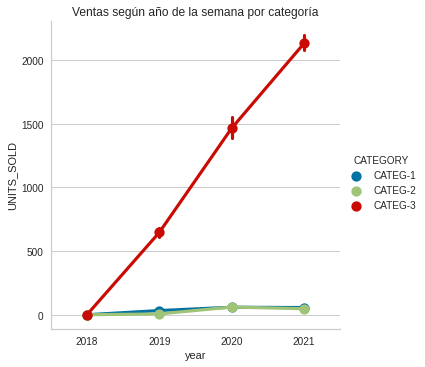

In [26]:
sns.factorplot(data = df_si, x = "year", y = "UNITS_SOLD", hue = "CATEGORY").set(title='Ventas según año de la semana por categoría')
plt.show()

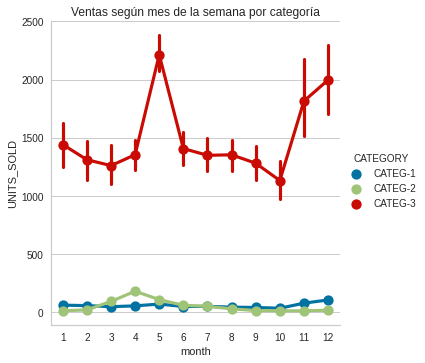

In [27]:
sns.factorplot(data = df_si, x = "month", y = "UNITS_SOLD", hue = "CATEGORY").set(title='Ventas según mes de la semana por categoría')
plt.show()

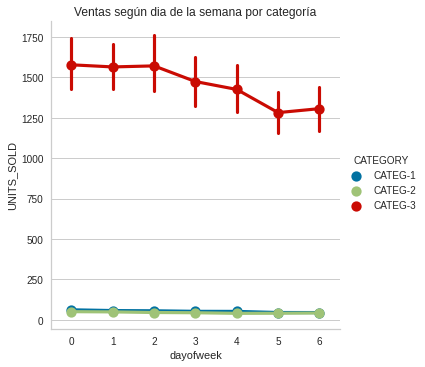

In [28]:
# domingo=0
# del domingo al sabado las ventas dcrecen
sns.factorplot(data = df_si, x = "dayofweek", y = "UNITS_SOLD", hue = "CATEGORY").set(title='Ventas según dia de la semana por categoría')
plt.show()

### Estacionaridad y estacionalidad de las series

In [29]:
long_vtas=df_si.groupby(['DATE','CATEGORY','year', 'month', 'day']).agg({'UNITS_SOLD':'sum'}).reset_index()
long_vtas.head(2)

,DATE,CATEGORY,year,month,day,UNITS_SOLD
0,2018-09-24,CATEG-3,2018,9,24,0
1,2018-09-25,CATEG-3,2018,9,25,0


In [30]:
wide_vtas=pd.pivot(long_vtas, index=['DATE'], columns = 'CATEGORY',values = 'UNITS_SOLD')
wide_vtas_si=wide_vtas.reset_index()
wide_vtas_si.head()

CATEGORY,DATE,CATEG-1,CATEG-2,CATEG-3
0,2018-09-24,NaN,NaN,0.0
1,2018-09-25,NaN,NaN,0.0
2,2018-09-27,NaN,NaN,0.0
3,2018-09-28,NaN,NaN,2.0
4,2018-09-29,NaN,NaN,1.0


In [31]:
wide_vtas_si[wide_vtas_si['CATEG-1'].isnull()].max()

CATEGORY
DATE       2018-11-11 00:00:00
CATEG-1                    NaN
CATEG-2                    NaN
CATEG-3                    3.0
dtype: object

In [32]:
# me quedo con las series enteras 
wide=wide_vtas_si[wide_vtas_si['DATE']>'2018-11-11']

In [33]:
wide=wide.set_index('DATE')

In [34]:
wide['year'] = pd.DatetimeIndex(wide.index).year
wide['month'] = pd.DatetimeIndex(wide.index).month
wide['day'] = pd.DatetimeIndex(wide.index).day
wide['dayofweek']=pd.DatetimeIndex(wide.index).dayofweek

In [35]:
wide.head()

CATEGORY,CATEG-1,CATEG-2,CATEG-3,year,month,day,dayofweek
DATE,,,,,,,
2019-06-11,27.0,15.0,642.0,2019,6,11,1
2019-06-12,26.0,13.0,679.0,2019,6,12,2
2019-06-13,24.0,8.0,561.0,2019,6,13,3
2019-06-14,18.0,9.0,520.0,2019,6,14,4
2019-06-15,15.0,9.0,422.0,2019,6,15,5


In [36]:
#sales_1 = np.log2(df[df.CATEGORY == 'CATEG-1']['UNITS_SOLD'])
#sales_2 = np.log2(df[df.CATEGORY == 'CATEG-2']['UNITS_SOLD'])
#sales_3 = np.log2(df[df.CATEGORY == 'CATEG-3']['UNITS_SOLD'])

In [37]:
#logs
logs=wide.copy()
logs['v_c1'] = np.log2(logs['CATEG-1'])
logs['v_c2'] = np.log2(logs['CATEG-2'])
logs['v_c3'] = np.log2(logs['CATEG-3'])
logs.head()

CATEGORY,CATEG-1,CATEG-2,CATEG-3,year,month,day,dayofweek,v_c1,v_c2,v_c3
DATE,,,,,,,,,,
2019-06-11,27.0,15.0,642.0,2019,6,11,1,4.754888,3.906891,9.326429
2019-06-12,26.0,13.0,679.0,2019,6,12,2,4.700440,3.700440,9.407268
2019-06-13,24.0,8.0,561.0,2019,6,13,3,4.584963,3.000000,9.131857
2019-06-14,18.0,9.0,520.0,2019,6,14,4,4.169925,3.169925,9.022368
2019-06-15,15.0,9.0,422.0,2019,6,15,5,3.906891,3.169925,8.721099


In [38]:
logs.columns

Index(['CATEG-1', 'CATEG-2', 'CATEG-3', 'year', 'month', 'day', 'dayofweek',
       'v_c1', 'v_c2', 'v_c3'],
      dtype='object', name='CATEGORY')

In [39]:
logs_si=logs.reset_index()

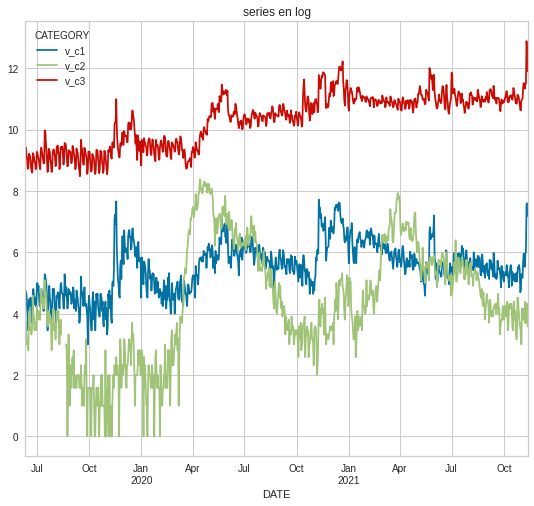

In [40]:
logs_si.plot(x='DATE', y=['v_c1', 'v_c2', 'v_c3'], kind="line", figsize=(9, 8))
plt.title('series en log')
plt.show()

In [41]:
logs_si['dv_c1'] = logs_si['v_c1'].diff()
logs_si['dv_c2'] = logs_si['v_c1'].diff()
logs_si['dv_c3'] = logs_si['v_c1'].diff()

In [42]:
logs_si.head()

CATEGORY,DATE,CATEG-1,CATEG-2,CATEG-3,year,month,day,dayofweek,v_c1,v_c2,v_c3,dv_c1,dv_c2,dv_c3
0,2019-06-11,27.0,15.0,642.0,2019,6,11,1,4.754888,3.906891,9.326429,NaN,NaN,NaN
1,2019-06-12,26.0,13.0,679.0,2019,6,12,2,4.700440,3.700440,9.407268,-0.054448,-0.054448,-0.054448
2,2019-06-13,24.0,8.0,561.0,2019,6,13,3,4.584963,3.000000,9.131857,-0.115477,-0.115477,-0.115477
3,2019-06-14,18.0,9.0,520.0,2019,6,14,4,4.169925,3.169925,9.022368,-0.415037,-0.415037,-0.415037
4,2019-06-15,15.0,9.0,422.0,2019,6,15,5,3.906891,3.169925,8.721099,-0.263034,-0.263034,-0.263034


In [43]:
logs_si=logs_si.iloc[1:]

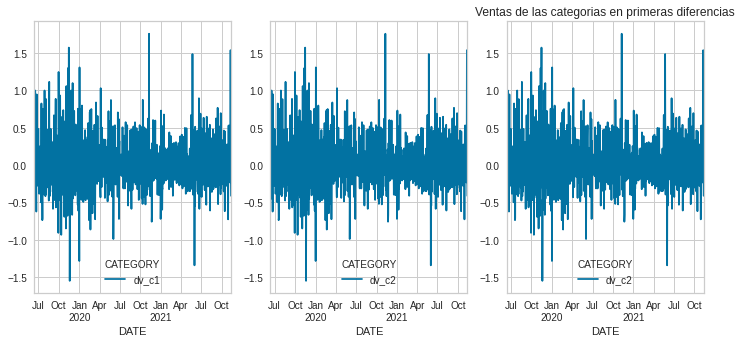

In [44]:
fig, axs = plt.subplots(ncols=3, figsize=(12,5))
logs_si.plot(x='DATE', y=['dv_c1'], kind="line", ax=axs[0])
logs_si.plot(x='DATE', y=['dv_c2'], kind="line", ax=axs[1])
logs_si.plot(x='DATE', y=['dv_c2'], kind="line", ax=axs[2])
plt.title('Ventas de las categorias en primeras diferencias')
plt.show()

In [45]:
logs=logs_si.set_index('DATE')

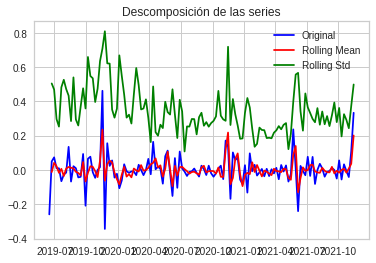

Results of Dickey-Fuller Test, model constant only:
ADF Statistic: -8.014786
p-value: 0.000000
Critical Values:
1% -3.437941243806186
5% -2.8648909885419247
10% -2.5685543184692214
Results of Dickey-Fuller Test, model constant and trend:
ADF Statistic: -7.989795
p-value: 0.000000
Critical Values:
1% -3.9692864149198264
5% -3.4155836563842317
10% -3.130047885189978
Results of Dickey-Fuller Test, model no constant and trend:
ADF Statistic: -8.000209
p-value: 0.000000
Critical Values:
1% -2.568332590181327
5% -1.9413153389465831
10% -1.6165161889193222


In [46]:
# Function to test the stationarity
def test_stationarity(timeseries):
    
    # Determing rolling statistics
    roll_mean = timeseries.rolling(window=7).mean()
    roll_std = timeseries.rolling(window=7).std()
# Plotting rolling statistics:
    orig = plt.plot(timeseries.resample('W').mean(), color='blue',label='Original')
    mean = plt.plot(roll_mean.resample('W').mean(), color='red', label='Rolling Mean')
    std = plt.plot(roll_std.resample('W').mean(), color='green', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Descomposición de las series')
    plt.show(block=False)
    
  # Performing Dickey-Fuller test:
    print('Results of Dickey-Fuller Test, model constant only:')
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
           print(key, value)
    # Performing Dickey-Fuller test, constant and trend:
    print('Results of Dickey-Fuller Test, model constant and trend:')
    result = adfuller(timeseries, autolag='AIC',regression='ct' )
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
           print(key, value) 
      # Performing Dickey-Fuller test, no constant, no trend:
    print('Results of Dickey-Fuller Test, model no constant and trend:')
    result = adfuller(timeseries, autolag='AIC',regression='nc' )
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
           print(key, value)                 
# Testing stationarity of store type a
test_stationarity(logs.dv_c1)

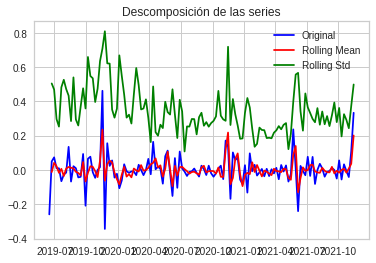

Results of Dickey-Fuller Test, model constant only:
ADF Statistic: -8.014786
p-value: 0.000000
Critical Values:
1% -3.437941243806186
5% -2.8648909885419247
10% -2.5685543184692214
Results of Dickey-Fuller Test, model constant and trend:
ADF Statistic: -7.989795
p-value: 0.000000
Critical Values:
1% -3.9692864149198264
5% -3.4155836563842317
10% -3.130047885189978
Results of Dickey-Fuller Test, model no constant and trend:
ADF Statistic: -8.000209
p-value: 0.000000
Critical Values:
1% -2.568332590181327
5% -1.9413153389465831
10% -1.6165161889193222


In [47]:
test_stationarity(logs.dv_c2)

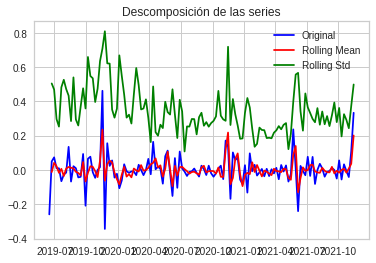

Results of Dickey-Fuller Test, model constant only:
ADF Statistic: -8.014786
p-value: 0.000000
Critical Values:
1% -3.437941243806186
5% -2.8648909885419247
10% -2.5685543184692214
Results of Dickey-Fuller Test, model constant and trend:
ADF Statistic: -7.989795
p-value: 0.000000
Critical Values:
1% -3.9692864149198264
5% -3.4155836563842317
10% -3.130047885189978
Results of Dickey-Fuller Test, model no constant and trend:
ADF Statistic: -8.000209
p-value: 0.000000
Critical Values:
1% -2.568332590181327
5% -1.9413153389465831
10% -1.6165161889193222


In [48]:
test_stationarity(logs.dv_c3)

$\text{H0) Raíz unitaria, H1) No Raíz unitaria}$ cuando el p-valor está por debajo de un determinado valore crítico, entonces no se rechaza $H_0$. Para el modelo con constante sólo y para el modelo con constante y con tendencia los p-valores son inferiores a un valor crítico de 0.05, entonces no se rechaza $H_0$.
En primeras diferencias, las series son estacionarias. Con esto en mente se podría pensar en modelizar las series con SARIMAS, detectandos patrones estacionales y probar de ajustar distintos modelos para compararlos con los resultados que siguen a continuación.

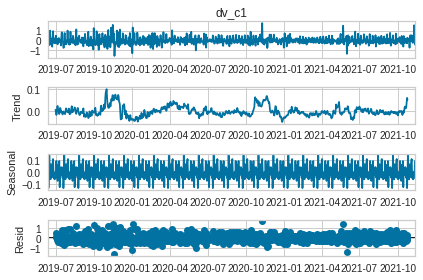

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
result1=seasonal_decompose(logs.dv_c1, model='additive', period=36)
result1.plot()
pyplot.show()

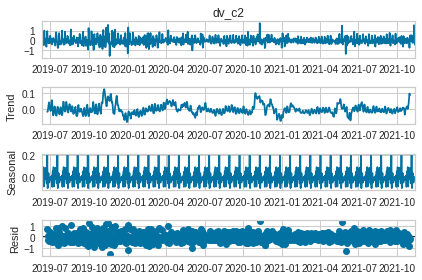

In [50]:
result2=seasonal_decompose(logs.dv_c2, model='additive', period=24)
result2.plot()
pyplot.show()

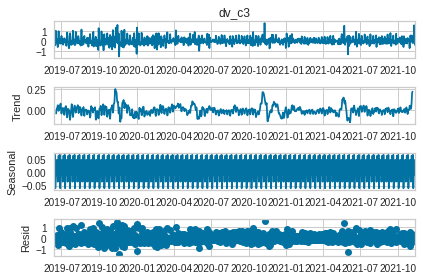

In [51]:
result3=seasonal_decompose(logs.dv_c3, model='additive',period=12)
result3.plot()
pyplot.show()

## Modelos para la series temporales univariadas

In [52]:
df.columns

Index(['CATEGORY', 'UNITS_SOLD', 'year', 'month', 'day', 'dayofweek'], dtype='object')

#### Defino las muestras de train y test 

In [53]:
wide.shape[0]*0.8

708.8000000000001

In [54]:
wide=wide.reset_index()

In [55]:
train=wide.iloc[:707,:]
train.tail()

CATEGORY,DATE,CATEG-1,CATEG-2,CATEG-3,year,month,day,dayofweek
702,2021-05-13,32.0,46.0,2063.0,2021,5,13,3
703,2021-05-14,30.0,40.0,1918.0,2021,5,14,4
704,2021-05-15,24.0,32.0,1814.0,2021,5,15,5
705,2021-05-16,32.0,42.0,1824.0,2021,5,16,6
706,2021-05-17,51.0,50.0,2513.0,2021,5,17,0


In [56]:
test=wide.iloc[707:,:]
test.head()

CATEGORY,DATE,CATEG-1,CATEG-2,CATEG-3,year,month,day,dayofweek
707,2021-05-18,49.0,46.0,2445.0,2021,5,18,1
708,2021-05-19,46.0,47.0,2340.0,2021,5,19,2
709,2021-05-20,40.0,51.0,2315.0,2021,5,20,3
710,2021-05-21,42.0,44.0,2082.0,2021,5,21,4
711,2021-05-22,36.0,34.0,1970.0,2021,5,22,5


In [57]:
train.shape, test.shape

((707, 8), (179, 8))

In [58]:
train.columns

Index(['DATE', 'CATEG-1', 'CATEG-2', 'CATEG-3', 'year', 'month', 'day',
       'dayofweek'],
      dtype='object', name='CATEGORY')

#### Análisis para la categoría 1

In [59]:
train1=train[['year',	'month'	,'day', 'CATEG-1']]

In [60]:
test1=test[['year',	'month'	,'day', 'CATEG-1']]

In [61]:
wide.columns

Index(['DATE', 'CATEG-1', 'CATEG-2', 'CATEG-3', 'year', 'month', 'day',
       'dayofweek'],
      dtype='object', name='CATEGORY')

In [62]:
wide1=wide[['year',	'month'	,'day', 'CATEG-1']]

In [63]:
# initialize setup
s = setup(data = train1, test_data = test1, target = 'CATEG-1', fold_strategy = 'timeseries', numeric_features = ['year', 'month','day'],fold = 3, transform_target = True, session_id = 123)


,Description,Value
0,session_id,123
1,Target,CATEG-1
2,Original Data,"(707, 4)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(707, 3)"


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=['year', 'month',
                                                          'day'],
                                      target='CATEG-1', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=N...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_all', 'pa

In [64]:
best = compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,27.5966,1314.1292,36.0439,-0.5405,0.6813,0.4044,0.0633
rf,Random Forest Regressor,28.1195,1386.7173,36.8897,-0.6030,0.7017,0.4061,0.4533
lightgbm,Light Gradient Boosting Machine,28.7250,1383.1353,36.9509,-0.6164,0.6626,0.4515,0.2700
et,Extra Trees Regressor,28.8796,1466.3541,37.8369,-0.6861,0.6752,0.4551,0.2300
omp,Orthogonal Matching Pursuit,29.4309,1634.3309,40.1961,-0.9215,0.6832,0.4441,0.0300
dt,Decision Tree Regressor,30.5777,1613.5170,39.8163,-0.8949,0.6930,0.4905,0.0400
en,Elastic Net,32.9780,1974.4604,43.7722,-1.2333,0.7560,0.4416,0.0333
llar,Lasso Least Angle Regression,32.9780,1974.4604,43.7722,-1.2333,0.7560,0.4416,0.0400
lasso,Lasso Regression,32.9780,1974.4604,43.7722,-1.2333,0.7560,0.4416,0.0600
dummy,Dummy Regressor,32.9780,1974.4604,43.7722,-1.2333,0.7560,0.4416,0.0233


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:PowerTransformedTargetRegressor(alpha=0.9, ccp_alpha=0.0,
                                criterion='friedman_mse', init=None,
                                learning_rate=0.1, loss='ls', max_depth=3,
                                max_features=None, max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_iter_no_change=None,
                                power_transformer_method...
                                                                    max_leaf_nodes=None,
                                                                    min_impurity_decrease=0.0,
                                           

The best model using 3 fold cross-validation based on Mean Absolute Error (MAE) is AdaBoost Regressor.

In [65]:
train1.columns

Index(['year', 'month', 'day', 'CATEG-1'], dtype='object', name='CATEGORY')

In [66]:
train.tail()# 2021-05-19

CATEGORY,DATE,CATEG-1,CATEG-2,CATEG-3,year,month,day,dayofweek
702,2021-05-13,32.0,46.0,2063.0,2021,5,13,3
703,2021-05-14,30.0,40.0,1918.0,2021,5,14,4
704,2021-05-15,24.0,32.0,1814.0,2021,5,15,5
705,2021-05-16,32.0,42.0,1824.0,2021,5,16,6
706,2021-05-17,51.0,50.0,2513.0,2021,5,17,0


In [67]:
# creo fechas futuras
future_dates = pd.date_range(start = '2021-11-13', end = '2021-12-04', freq = 'D')
future_df = pd.DataFrame()
future_df['month'] = [i.month for i in future_dates]
future_df['year'] = [i.year for i in future_dates]    
future_df['day'] = [i.day for i in future_dates] 
future_df.head()

,month,year,day
0,11,2021,13
1,11,2021,14
2,11,2021,15
3,11,2021,16
4,11,2021,17


In [68]:
predictions_future = predict_model(best, data=future_df)
predictions_future.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=PowerTransformedTargetRegressor(alpha=0.9, ccp_alpha=0.0,
                                criterion='friedman_mse', init=None,
                                learning_rate=0.1, loss='ls', max_depth=3,
                                max_features=None, max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                min_impurity_split=None, min_samples_leaf=1,
                                min_samples_split=2,
                                min_weight_fraction_leaf=0.0, n_estimators=100,
                                n_iter_no_change=None,
                                power_transformer_method...
                                                                    max_leaf_nodes=None,
                                                                    min_impurity_decrease=0.0,
                                                                    min_impurity_spli

,month,year,day,Label
0,11,2021,13,65.797405
1,11,2021,14,65.797405
2,11,2021,15,69.031402
3,11,2021,16,69.031402
4,11,2021,17,67.173843


In [69]:
wide1.tail()

CATEGORY,year,month,day,CATEG-1
881,2021,11,8,63.0
882,2021,11,9,65.0
883,2021,11,10,189.0
884,2021,11,11,194.0
885,2021,11,12,146.0


In [70]:
concat_df = pd.concat([wide1,predictions_future], axis=0)
concat_df.head()

,year,month,day,CATEG-1,Label
0,2019,6,11,27.0,NaN
1,2019,6,12,26.0,NaN
2,2019,6,13,24.0,NaN
3,2019,6,14,18.0,NaN
4,2019,6,15,15.0,NaN


In [71]:
concat_df['fechas']=pd.to_datetime(concat_df[['year', 'month', 'day']])

In [72]:
concat_df.set_index('fechas', inplace=True)

In [73]:
fig = px.line(concat_df, x=concat_df.index, y=['CATEG-1', 'Label'], template = 'plotly_dark',title='proyecciones de ventas categoría 1')
fig.show()

#### Análisis para la categoría 2

In [74]:
train2=train[['year',	'month'	,'day', 'CATEG-2']]
test2=test[['year',	'month'	,'day', 'CATEG-2']]

In [75]:
wide2=wide[['year',	'month'	,'day', 'CATEG-2']]

In [76]:
s = setup(data = train2, test_data = test2, target = 'CATEG-2', fold_strategy = 'timeseries', numeric_features = ['year', 'month','day'],fold = 3, transform_target = True, session_id = 123)

,Description,Value
0,session_id,123
1,Target,CATEG-2
2,Original Data,"(707, 4)"
3,Missing Values,True
4,Numeric Features,3
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(699, 3)"


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=['year', 'month',
                                                          'day'],
                                      target='CATEG-2', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=N...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_all', 'pa

In [77]:
best2 = compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ada,AdaBoost Regressor,44.2069,6258.9409,66.6480,0.0189,1.4784,0.8710,0.0733
knn,K Neighbors Regressor,50.7359,6766.7761,74.3580,-0.3183,1.4374,1.0774,0.0900
rf,Random Forest Regressor,51.8248,7560.8757,78.1175,-0.5165,1.3533,1.0361,0.2567
et,Extra Trees Regressor,52.1420,7463.4068,76.5063,-0.4569,1.2604,1.1744,0.1967
dummy,Dummy Regressor,53.5762,7876.0925,82.5101,-0.7283,1.6831,0.6657,0.0200
llar,Lasso Least Angle Regression,53.5762,7876.0925,82.5101,-0.7283,1.6831,0.6657,0.0200
gbr,Gradient Boosting Regressor,53.5863,7457.2396,78.6362,-0.5178,1.3666,1.0189,0.0667
lasso,Lasso Regression,53.5973,7801.1230,82.2232,-0.7217,1.6491,0.7473,0.0267
en,Elastic Net,53.8334,7514.9605,80.8605,-0.6758,1.5779,1.1368,0.0200
lightgbm,Light Gradient Boosting Machine,54.9177,8177.5287,84.3587,-0.8563,1.3564,1.0820,0.0400


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:PowerTransformedTargetRegressor(base_estimator=None, learning_rate=1.0,
                                loss='linear', n_estimators=50,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=123,
                                regressor=AdaBoostRegressor(base_estimator=None,
                                                            learning_rate=1.0,
                                                            loss='linear',
                                                            n_estimators=50,
                                                            random_state=123))
INFO:logs:compare_models() succesfully completed......................................


In [78]:
predictions_future2 = predict_model(best2, data=future_df)
predictions_future2.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=PowerTransformedTargetRegressor(base_estimator=None, learning_rate=1.0,
                                loss='linear', n_estimators=50,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=123,
                                regressor=AdaBoostRegressor(base_estimator=None,
                                                            learning_rate=1.0,
                                                            loss='linear',
                                                            n_estimators=50,
                                                            random_state=123)), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:log

,month,year,day,Label
0,11,2021,13,15.786286
1,11,2021,14,15.786286
2,11,2021,15,15.786286
3,11,2021,16,15.786286
4,11,2021,17,15.786286


In [79]:
concat_df2 = pd.concat([wide2,predictions_future2], axis=0)
concat_df2['fechas']=pd.to_datetime(concat_df2[['year', 'month', 'day']])
concat_df2.set_index('fechas', inplace=True)
fig = px.line(concat_df2, x=concat_df2.index, y=['CATEG-2', 'Label'], template = 'plotly_dark',title='proyecciones de ventas categoría 2')
fig.show()

#### Análisis para la categoría 3

In [80]:
# cat 3
train3=train[['year',	'month'	,'day', 'CATEG-3']]


In [81]:
test3=test[['year',	'month'	,'day', 'CATEG-3']]
wide3=wide[['year',	'month'	,'day', 'CATEG-3']]


In [82]:
s = setup(data = train3, test_data = test3, target = 'CATEG-3', fold_strategy = 'timeseries', numeric_features = ['year', 'month','day'],fold = 3, transform_target = True, session_id = 123)


,Description,Value
0,session_id,123
1,Target,CATEG-3
2,Original Data,"(707, 4)"
3,Missing Values,False
4,Numeric Features,3
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(707, 3)"


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=['year', 'month',
                                                          'day'],
                                      target='CATEG-3', time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=N...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),
                ('cluster_all', 'pa

In [83]:
best3 = compare_models(sort = 'MAE')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
ridge,Ridge Regression,597.7266,6.681966e+05,812.0846,-1.2445,0.4849,0.3750,0.0433
et,Extra Trees Regressor,659.4275,7.448642e+05,832.0712,-1.4843,0.6317,0.3824,0.3200
br,Bayesian Ridge,676.0114,9.474847e+05,941.3095,-2.1233,0.5089,0.4137,0.0667
omp,Orthogonal Matching Pursuit,689.4645,8.305913e+05,898.5640,-1.7632,0.6492,0.4050,0.0433
dt,Decision Tree Regressor,691.4091,7.921818e+05,863.5042,-1.6333,0.6471,0.4077,0.0800
lightgbm,Light Gradient Boosting Machine,711.7066,8.271905e+05,886.7313,-1.7485,0.6594,0.4259,0.0700
lar,Least Angle Regression,732.6334,1.211363e+06,1036.8839,-2.9572,0.5321,0.4451,0.0467
lr,Linear Regression,733.1258,1.214557e+06,1037.9116,-2.9672,0.5323,0.4454,0.0400
rf,Random Forest Regressor,745.7724,8.687074e+05,908.7830,-1.8750,0.7441,0.4272,0.4600
gbr,Gradient Boosting Regressor,763.6856,8.973202e+05,924.2805,-1.9650,0.7626,0.4401,0.1067


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 2
INFO:logs:PowerTransformedTargetRegressor(alpha=1.0, copy_X=True, fit_intercept=True,
                                max_iter=None, normalize=False,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=123,
                                regressor=Ridge(alpha=1.0, copy_X=True,
                                                fit_intercept=True,
                                                max_iter=None, normalize=False,
                                                random_state=123, solver='auto',
                                                tol=0.001),
                                solver='auto', tol=0.001)
INFO:logs:compare_models() succesfully completed......................................


In [84]:
predictions_future3 = predict_model(best3, data=future_df)
predictions_future3.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=PowerTransformedTargetRegressor(alpha=1.0, copy_X=True, fit_intercept=True,
                                max_iter=None, normalize=False,
                                power_transformer_method='box-cox',
                                power_transformer_standardize=True,
                                random_state=123,
                                regressor=Ridge(alpha=1.0, copy_X=True,
                                                fit_intercept=True,
                                                max_iter=None, normalize=False,
                                                random_state=123, solver='auto',
                                                tol=0.001),
                                solver='auto', tol=0.001), probability_threshold=None, encoded_labels=True, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.REGRESSION, display=None, drift_kwargs=None)
INFO:l

,month,year,day,Label
0,11,2021,13,5086.192871
1,11,2021,14,5093.885742
2,11,2021,15,5102.299805
3,11,2021,16,5110.016602
4,11,2021,17,5117.744629


In [85]:
concat_df3 = pd.concat([wide3,predictions_future3], axis=0)
concat_df3['fechas']=pd.to_datetime(concat_df3[['year', 'month', 'day']])
concat_df3.set_index('fechas', inplace=True)
fig = px.line(concat_df3, x=concat_df3.index, y=['CATEG-3', 'Label'], template = 'plotly_dark',title='proyecciones de ventas categoría 3')
fig.show()

## Fuentes

* https://builtin.com/data-science/time-series-forecasting-python

* https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

* https://www.datacamp.com/tutorial/tutorial-time-series-forecasting

* https://towardsdatascience.com/time-series-forecasting-based-on-the-trend-and-seasonal-components-26b92866e548